In [1]:
from __future__ import print_function
import random, numpy as np
import keras, tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.utils import image_dataset_from_directory
from keras.layers import Dense, Dropout, Activation, Flatten, Rescaling, RandomRotation, RandomFlip, RandomCrop, RandomTranslation
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import *

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

## Set random seed

In [2]:
import random, os, tensorflow as tf

def set_seed(seed_value=12345):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # to Disable GPU training

In [3]:
print('Default GPU Device:', tf.test.gpu_device_name() or 'None')

Default GPU Device: /device:GPU:0


In [4]:
data = './KanjiN5_dataset'

## Model Training

In [5]:
num_classes = 81
batch_size = 64
image_size = 120

In [6]:
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
                                                height_shift_range=0.1,
                                                width_shift_range=0.1,
                                                zoom_range=0.1,
                                                rescale=1./255
)

In [7]:
train_ds = data_augmentation.flow_from_directory(
    directory=os.path.join(data, "Train"),
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=True
)

valid_ds = data_augmentation.flow_from_directory(
    directory=os.path.join(data, "Valid"),
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

test_ds = data_augmentation.flow_from_directory(
    directory=os.path.join(data, "Test"),
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 9071 images belonging to 81 classes.
Found 2592 images belonging to 81 classes.
Found 1377 images belonging to 81 classes.


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Rescaling
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(6, (5,5), input_shape=(image_size, image_size, 3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(16, (5,5), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 116, 116, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 58, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 54, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 27, 27, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 27, 27, 16)        0         
                                                                 
 flatten (Flatten)           (None, 11664)             0

In [10]:
callback = [keras.callbacks.EarlyStopping(patience=10, monitor='val_accuracy')]
# https://stackoverflow.com/questions/73304934/tensorflow-data-augmentation-gives-a-warning-using-a-while-loop-for-converting
# https://medium.com/featurepreneur/data-augmentation-using-keras-preprocessing-layers-6cdc7d49328e

In [11]:
epochs = 100
earlystop = 1
if earlystop:
    history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=callback)
else:
    history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Epoch 1/100
142/142 [==============================] - 32s 211ms/step - loss: 4.0152 - accuracy: 0.0719 - val_loss: 2.8984 - val_accuracy: 0.2623
Epoch 2/100
142/142 [==============================] - 30s 211ms/step - loss: 1.8292 - accuracy: 0.5003 - val_loss: 1.1203 - val_accuracy: 0.6771
Epoch 3/100
142/142 [==============================] - 30s 209ms/step - loss: 0.8641 - accuracy: 0.7420 - val_loss: 0.6127 - val_accuracy: 0.8214
Epoch 4/100
142/142 [==============================] - 29s 205ms/step - loss: 0.5487 - accuracy: 0.8357 - val_loss: 0.4691 - val_accuracy: 0.8677
Epoch 5/100
142/142 [==============================] - 29s 205ms/step - loss: 0.4297 - accuracy: 0.8662 - val_loss: 0.4167 - val_accuracy: 0.8742
Epoch 6/100
142/142 [==============================] - 29s 204ms/step - loss: 0.3499 - accuracy: 0.8874 - val_loss: 0.4056 - val_accuracy: 0.8785
Epoch 7/100
142/142 [==============================] - 29s 203ms/step - loss: 0.3061 - accuracy: 0.9056 - val_loss: 0.2632 -

## Loss visualization 

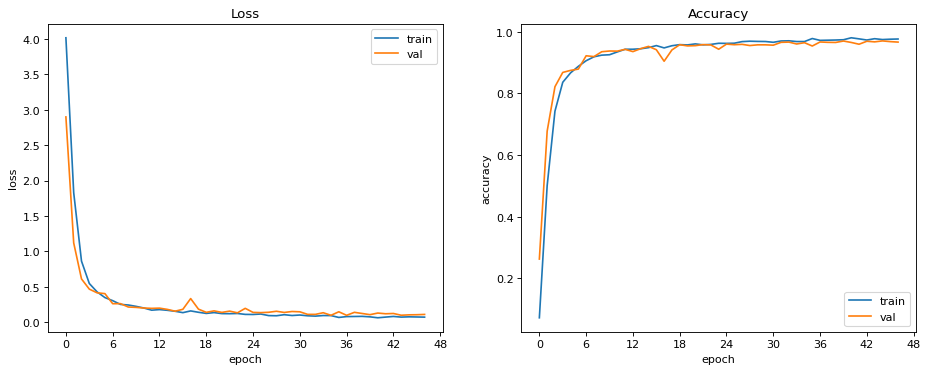

In [12]:
# Loss accuracy
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['accuracy'])

ax.plot(history.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

In [13]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(train_ds, verbose=0)))
print('Validation Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(valid_ds, verbose=0)))
print('Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(test_ds, verbose=0)))



Train Loss: 0.038875, Accuracy: 0.987212
Validation Loss: 0.099707, Accuracy: 0.966821
Test Loss: 0.022804, Accuracy: 0.992012


In [14]:

from sklearn.metrics import classification_report
 

## Create Confusion Matrix
using seaborn and matplotlib.

In [15]:
# Generate predictions
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_ds.classes



22/22 [==============================] - 4s 165ms/step


In [20]:
# Generate classification report
report = classification_report(true_labels, y_pred, target_names=list(train_ds.class_indices.keys()))
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           一       1.00      1.00      1.00        17
           七       1.00      1.00      1.00        17
           万       1.00      0.94      0.97        17
           三       1.00      1.00      1.00        17
           上       1.00      1.00      1.00        17
           下       1.00      1.00      1.00        17
           中       1.00      1.00      1.00        17
           九       0.94      1.00      0.97        17
           二       1.00      1.00      1.00        17
           五       1.00      1.00      1.00        17
           人       0.94      1.00      0.97        17
           今       1.00      1.00      1.00        17
           休       1.00      1.00      1.00        17
           何       1.00      1.00      1.00        17
           先       1.00      1.00      1.00        17
           入       0.94      1.00      0.97        17
           八       1.00      0.94      0.97        17
    

In [21]:
y_pred = model.predict(test_ds)
y_pred = y_pred.argmax(axis=1)
print(y_pred[0:10], type(y_pred))

22/22 [==============================] - 3s 158ms/step
[0 0 0 0 0 0 0 0 0 0] <class 'numpy.ndarray'>


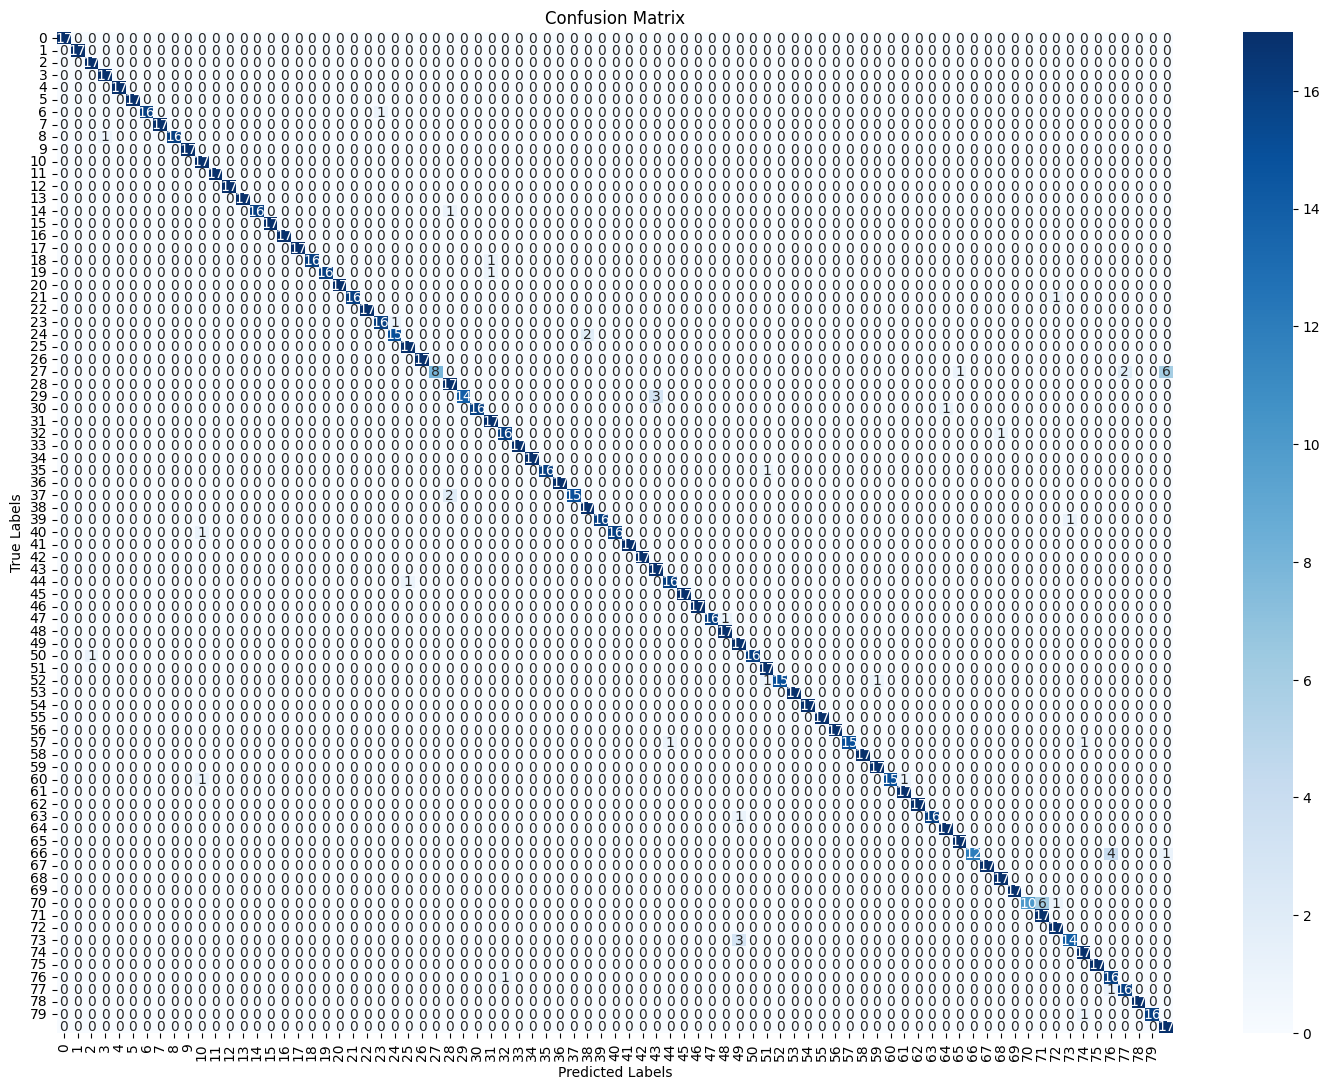

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(true_labels, y_pred)
# Define class labels (assuming your classes are named '0', '1', ..., '19')
class_names = [i for i in range(80)]

# Plot confusion matrix
plt.figure(figsize=(18, 13))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [16]:
model.save('Lenet5_Dropout2.h5')